# Figure 14.

Vertical profiles of temperature increments due to the latent heating averaged over the center part of the *HighRes* domain in (light blue) global and (dark blue) *HighRes* simulations of (a) Trappist-1e and (b) Proxima b. Thin lines represent spatial averages for each day of the 10-day analysis window, thick lines are the 10-day mean.

[Skip code and jump to the figure](#Show-the-figure)

----------------------------------

Import the necessary libraries.

In [1]:
import warnings

warnings.filterwarnings("ignore")

Scientific stack

In [2]:
import iris

import numpy as np

import matplotlib.pyplot as plt

In [3]:
from aeolus.coord_utils import UM_HGT, UM_TIME
from aeolus.core import Run
from aeolus.util import subplot_label_generator

Local modules

In [4]:
from commons import (
    NS_COLORS,
    NS_MODEL_TYPES,
    NS_OUTPUT_NAME_PREFIX,
    NS_RUN_ALIASES,
    PLANET_ALIASES,
)
import mypaths
from plot_func import add_aux_yticks, add_custom_legend, use_style
from utils import tex2cf_units

Global stylesheet for figures.

In [5]:
use_style()

Local definitions

In [6]:
run_key = "grcs"

Set the method of calculating the latent heating.

In [7]:
def latent_heating(cubelist):
    lsppn = cubelist.extract_strict(
        "change_over_time_in_air_temperature_due_to_stratiform_precipitation"
    )
    lh = lsppn.copy()
    try:
        lh += cubelist.extract_strict(
            "change_over_time_in_air_temperature_due_to_convection"
        )
    except iris.exceptions.ConstraintMismatchError:
        # HighRes does not have convection parameterization
        pass
    lh.rename("change_over_time_in_air_temperature_due_to_latent_heat_release")
    return lh


vrbls2plot = {
    "t_incr_lh": {
        "func": latent_heating,
        "tex_units": "$K$ $day^{-1}$",
        "xlabel": "$\Delta T_{LH}$",
    },
}

## Load data

Create a dictionary of `Run` objects with preprocessed UM data.

In [8]:
runs = {}
for planet in PLANET_ALIASES.keys():
    for model_type, model_specs in NS_MODEL_TYPES.items():
        label = f"{planet}_{run_key}_{model_type}"
        try:
            runs[label] = Run(
                files=mypaths.nsdir / "_processed" / f"ns_area_mean_vprof_{label}.nc",
                name=label,
                planet=planet,
                model_type=model_type,
                processed=True,
            )
        except OSError as e:
            print(e)
            pass

## Plot the results

Set axes tick locations.

In [9]:
hgt_ticks = np.array([0, 1, 2, 5, 10, 15, 40])

Set title styles.

In [10]:
ttl_kw = dict(fontsize="small", pad=5, loc="left")
cb_ttl_kw = dict(fontsize="x-small", pad=5)

Set background and foreground line styles.

In [11]:
bg_kw = dict(alpha=0.25, linewidth=0.75)
fg_kw = dict(alpha=1.0, linewidth=2)

Assemble the plot.

In [12]:
nrows = 1
ncols = len(PLANET_ALIASES)

fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(9 * ncols, 6 * nrows),)

iletters = subplot_label_generator()
for planet, ax in zip(PLANET_ALIASES.keys(), axs):
    ax.set_title(f"({next(iletters)})", fontsize="small", loc="left")
    if ax.is_first_row():
        ax.set_title(PLANET_ALIASES[planet], fontsize="large", loc="center")
    ax2 = None
    for model_type in NS_MODEL_TYPES.keys():
        label = f"{planet}_{run_key}_{model_type}"

        pres = (
            runs[label]
            .proc.extract_strict("air_pressure")
            .collapsed(UM_TIME, iris.analysis.MEAN)
        )
        pres_points = pres.data * 1e-2
        if ax2 is None:
            # assume the vertical pressure distribution is roughly the same in all experiments
            hgt_points = pres.coord(UM_HGT).points * 1e-3

            ax.set_ylim(1000, 1)
            ax2 = add_aux_yticks(
                ax,
                hgt_points,
                pres_points,
                hgt_ticks,
                twin_ax_ylim=[0, 40],
                twin_ax_inv=True,
            )
        for (vrbl, vrbl_dict) in vrbls2plot.items():
            tex_units = vrbl_dict["tex_units"]

            cube = vrbl_dict["func"](runs[label].proc)
            cube.convert_units(tex2cf_units(tex_units))
            for cube_sl in cube.slices(UM_HGT):
                ax.plot(
                    cube_sl.data,
                    pres_points,
                    color=NS_COLORS[run_key][model_type],
                    **bg_kw,
                )
            ax.plot(
                cube.collapsed(UM_TIME, iris.analysis.MEAN).data,
                pres_points,
                color=NS_COLORS[run_key][model_type],
                **fg_kw,
            )
    ax.set_xlabel(f"Temperature increment due to latent heating [{tex_units}]", fontsize="large")
    ax.set_xlim([-15, 15])
    ax.vlines(0.0, 1000, 1, linestyle="-", linewidth=0.5, alpha=0.5)

    if ax.is_first_col():
        ax.set_ylabel("Pressure [$hPa$]", fontsize="large")
    elif ax.is_last_col():
        ax2.set_ylabel("Height [km]", fontsize="large")

add_custom_legend(
    axs.flatten()[0],
    {
        v["title"]: dict(color=NS_COLORS[run_key][k], **fg_kw)
        for k, v in NS_MODEL_TYPES.items()
    },
    loc=1,
    title="Simulations",
)

plt.subplots_adjust(wspace=0.2, hspace=0.2)
plt.close()  # Show the figure in a separate cell

## Show the figure

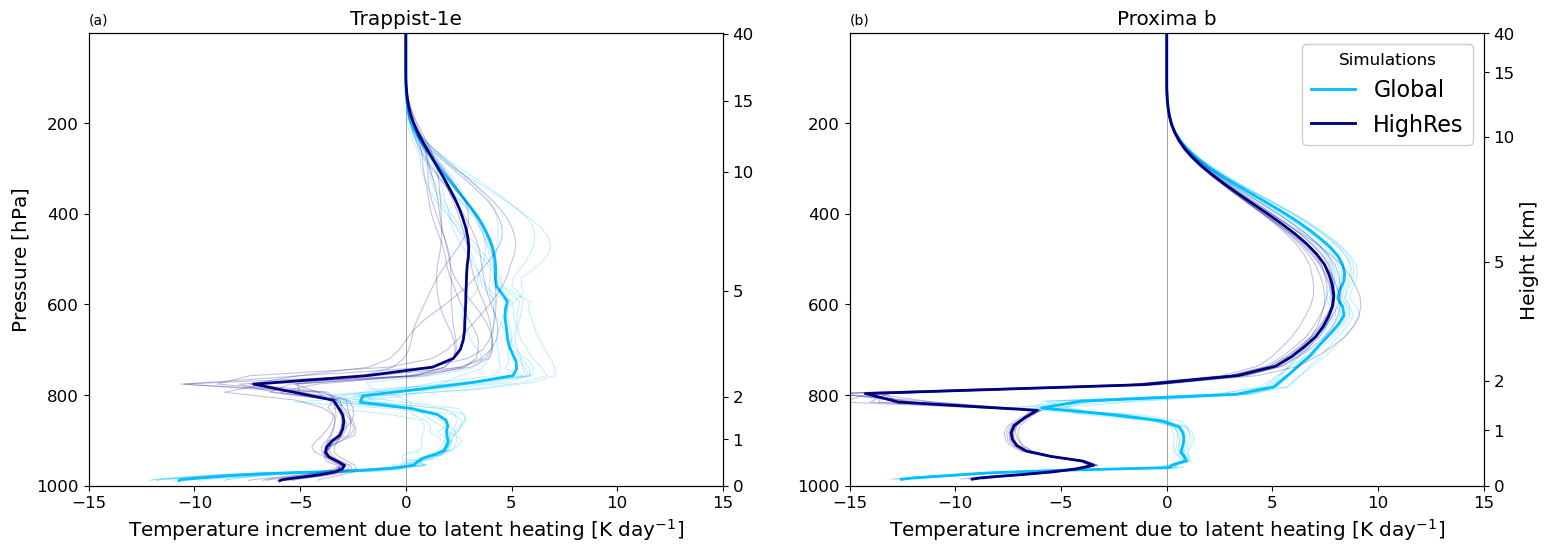

In [13]:
fig

And save it.

In [14]:
imgname = (
    mypaths.plotdir
    / f"{NS_OUTPUT_NAME_PREFIX}__vprof_{'_'.join(vrbls2plot.keys())}"
)

In [15]:
fig.savefig(imgname, dpi=200)
print(f"Saved to ../{imgname.relative_to(mypaths.topdir)}")

Saved to ../plots/trap1e_proxb__grcs__vprof_t_incr_lh
